In [62]:
import argparse
import glob
import json
import os
import random
import math
from collections import Counter
from tqdm import tqdm, trange

import numpy as np
import torch
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
#从pyplot导入MultipleLocator类，这个类用于设置刻度间隔
%matplotlib inline

LayerNorm = torch.nn.LayerNorm

In [63]:
class config():
    def __init__(
        self,
        vocab_size=25000,
        hidden_size=512,
        num_hidden_layers=3,
        num_attention_heads=8,
        intermediate_size=2048,
        hidden_act="relu",
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1,
        max_position_embeddings=32,
        type_vocab_size=2,
        initializer_range=0.02,
        layer_norm_eps=1e-12,
        norm_eps=1e-12,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.hidden_act = hidden_act
        self.intermediate_size = intermediate_size
        self.hidden_dropout_prob = hidden_dropout_prob
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.type_vocab_size = type_vocab_size
        self.initializer_range = initializer_range
        self.layer_norm_eps = layer_norm_eps
        self.norm_eps = norm_eps

In [64]:
"""Model"""

class EmbeddingLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids, position=None):
        embeddings = self.word_embeddings(input_ids)
        if position:
            embeddings += self.position_embeddings(position)
            
        return embeddings

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)


    def transpose_for_scores(self, x):
        # x : batch_size * max_seq * dim
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)  
        # new_x_shape: batch_size * max_seq * attention_heads * head_size
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)
        # return shape: batch_size * attention_heads * max_seq * head_size


    def forward(self, hidden_states, attention_mask):
        # hidden_states: batch_size * max_seq * embedding_dim
        
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)


        extended_attention_mask = attention_mask[:, None, None, :]
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        attention_mask = extended_attention_mask
        

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2)) 
        # batch_size * attention_heads * max_seq_a * max_seq_b
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_scores = attention_scores + attention_mask
        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        
        attention_probs = self.dropout(attention_probs)
        
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = context_layer

        return outputs

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.dense_2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.norm = LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, hidden_states):
        x = self.dense_1(hidden_states)
        x = nn.functional.relu(hidden_states)
        x = self.dropout(x)
        hidden_states = self.norm(x + hidden_states)

        return hidden_states


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadSelfAttention(config)
        self.norm = LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.feedforward = FeedForward(config)
    
    def forward(self, hidden_states, attention_mask):
        x = self.attention(hidden_states, attention_mask)
        hidden_states = self.norm(hidden_states + x)
        hidden_states = self.feedforward(hidden_states)

        return hidden_states


class Pooling(nn.Module):
    def forward(self, x, mask):
        # max pooling
        # print('mask:', mask)
        extended_mask = mask[:, :, None]
        extended_mask = (1.0 - extended_mask) * (-100000)
        mask = extended_mask
        # print('extended_mask:', mask)
        x = x + mask
        return x.max(dim=1)[0]


class Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embedding = EmbeddingLayer(config)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.num_hidden_layers)])
        self.pooling = Pooling()
        self.prediction = nn.Linear(config.hidden_size, 10)

        # self.init_weights()
        self.loss_fct = CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels):
        hidden_states = self.embedding(input_ids)
        for i, layer in enumerate(self.blocks):
            hidden_states = layer(hidden_states, attention_mask)
        outputs = self.pooling(hidden_states, attention_mask)
        outputs = self.prediction(outputs)
        loss = self.loss_fct(outputs.view(-1, 10), labels.view(-1))
        outputs = (loss, outputs)
        return outputs

In [65]:
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

def sentence2ids(args, sentence, word2id):
    if args.do_lower_case:
        sentence = sentence.lower()
    ids = []
    # for word in  sentence.strip().split():
    for word in  list(sentence.strip()):
        if word not in word2id.keys():
            ids.append(word2id['<UNK>'])
        else:
            ids.append(word2id[word])
    return ids


def load_vocab(args):
    import codecs
    vocab_path = os.path.join(args.data_dir, 'vocab.txt')

    if not os.path.exists(vocab_path):
        vocab = Counter()
        files = os.listdir(args.data_dir)
        for file in files:
            if not os.path.isdir(file) and file != '.DS_Store':
                # print('file:', file)
                f = codecs.open(os.path.join(args.data_dir, file), 'r')
                for line in f.readlines():
                    text, label = line.strip().split('\t')
                    if args.do_lower_case:
                        text = text.lower()
                        
                    vocab.update(list(text))
                f.close()
        f = codecs.open(os.path.join(args.data_dir+'/vocab.txt'), 'w')
        vocab = vocab.items()
        vocab = sorted(vocab, key=lambda x:x[1], reverse=True)
        f.write('<PAD>\n<UNK>\n')
        for _ in vocab:
            f.write(_[0] + '\n')   

    with open(vocab_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
    word2id = {}
    vocab = []
    for (index, line) in enumerate(lines):
        word = line.strip()
        vocab.append(word)
        word2id[word] = index

    return vocab, word2id

def load_dataset(args, word2id, data_type):
    data_path = os.path.join(args.data_dir, data_type+'.txt')

    # Read Data
    with open(data_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
    examples = []
    for (i, line) in enumerate(lines):
        if len(line.strip().split('\t')) == 2:
            text, label = line.strip().split('\t')
            examples.append((text, label))
            

    # Convert to features
    features = []
    for (ex_index, example) in enumerate(examples):
        len_examples = len(examples)
        if ex_index % 10000 == 0:
            print("Writing example %d/%d" % (ex_index, len_examples))

        input_ids = sentence2ids(args, example[0], word2id)
        attention_mask = [1] * len(input_ids)
        padding_length = args.max_seq_length - len(input_ids)
        input_ids = input_ids + ([0] * padding_length)
        attention_mask = attention_mask + ([0] * padding_length)

        label = int(example[1])

        input_ids = input_ids[:args.max_seq_length]
        attention_mask = attention_mask[:args.max_seq_length]
        
        features.append((input_ids, attention_mask, label))
       
        if ex_index == 1:
            print('input_sentence: ', example[0])
            print('input_ids: ', input_ids)
            print('attention_mask: ', attention_mask)            
            print('input_label: ', example[1])
            print('label: ', label)
        
        
    
    all_input_ids = torch.tensor([f[0] for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f[1] for f in features], dtype=torch.long)
    all_labels = torch.tensor([f[2] for f in features], dtype=torch.long)

    # print('1:', len(all_labels))
    dataset = TensorDataset(all_input_ids, all_attention_mask, all_labels)
    return dataset

In [66]:
# coding=utf-8

def train(args, train_dataset, model, tokenizer, word2id):
    """ Train the model """

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)
    print('train_dataset:', len(train_dataset))
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)

    t_total = len(train_dataloader) * args.num_train_epochs

    """
    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]


    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )

    # Check if saved optimizer or scheduler states exist
    if os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt")) and os.path.isfile(
        os.path.join(args.model_name_or_path, "scheduler.pt")
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))
    """

    # multi-gpu training (should be after apex fp16 initialization)
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)
    """
    
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    """
    # optimizer = torch.optim.Adam(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    # Train!
    
    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()

    train_iterator = range(epochs_trained, int(args.num_train_epochs))
    set_seed(args)  # Added here for reproductibility
    
    loss_show = []
    
    for _ in train_iterator:
        epoch_loss = 0.0
        
        # epoch_iterator = tqdm(train_dataloader, desc="Iteration")
        epoch_iterator = train_dataloader
        for step, batch in enumerate(epoch_iterator):

            model.train()
            batch = tuple(t.to(args.device) for t in batch)
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}

            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple 

            if args.n_gpu > 1:
                loss = loss.mean()  # mean() to average on multi-gpu parallel training

            loss.backward()

            tr_loss += loss.item()
            epoch_loss += loss.item()
            
            loss_show.append(loss.item())
            if(step + 1) % args.logging_steps == 0:
                print('train step:', step, 'total step:', len(epoch_iterator))
            
            
            optimizer.step()
            # scheduler.step()  # Update learning rate schedule

            model.zero_grad()
            global_step += 1

    

        print(" train average loss = %s", epoch_loss / step)
        
        # evaluate
        dev_dataset = load_dataset(args, word2id, 'dev')
        f1 = evaluate(args, dev_dataset, model, tokenizer, word2id)
        
    # show loss pic
    x = []
    y = loss_show
    for i in range(len(y)):
        x.append(i)

    
    plt.plot(x, y)
    plt.title('Loss Change')
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.grid(True)
    
    plt.show()


    return global_step, tr_loss / global_step


def evaluate(args, eval_dataset, model, tokenizer, word2id):

    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

    # multi-gpu eval
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Eval!
    print("***** Running evaluation *****")
    print("  Num examples = %d", len(eval_dataset))
    print("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(args.device) for t in batch)

        with torch.no_grad():
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs["labels"].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    preds = np.argmax(preds, axis=1)


    result = accuracy_score(out_label_ids, preds)
    print("eval average loss = %s, accuracy_score = %s", eval_loss, result)

    return result





In [67]:
def main():
    parser = argparse.ArgumentParser()

    parser.add_argument("--data_dir", default='news', type=str)
    parser.add_argument("--output_dir", default='output', type=str)

    # Other parameters
    parser.add_argument("--max_seq_length", default=32, type=int)
    parser.add_argument("--num_train_epochs", default=5, type=float)
    parser.add_argument("--do_train", default=True, type=bool)
    parser.add_argument("--do_test", default=True, type=bool)
    parser.add_argument("--do_lower_case", default=True, type=bool)
    parser.add_argument("--per_gpu_train_batch_size", default=64, type=int)
    parser.add_argument("--per_gpu_eval_batch_size", default=8, type=int)
    parser.add_argument("--learning_rate", default=1e-3, type=float)
    parser.add_argument("--weight_decay", default=0.01, type=float)
    parser.add_argument("--adam_epsilon", default=1e-8, type=float)
    parser.add_argument("--no_cuda", default=True, type=bool)
    parser.add_argument("--seed", default=42, type=int)
    
    parser.add_argument("--max_grad_norm", default=1.0, type=float, help="Max gradient norm.")
    parser.add_argument("--gradient_accumulation_steps", type=int, default=1, help="Number of updates steps to accumulate before performing a backward/update pass.",)
    parser.add_argument("--warmup_steps", default=0, type=int, help="Linear warmup over warmup_steps.")
    parser.add_argument("--logging_steps", type=int, default=100, help="Log every X updates steps.")
    parser.add_argument("--save_steps", type=int, default=500, help="Save checkpoint every X updates steps.")
    parser.add_argument("--max_steps", default=-1, type=int, help="If > 0: set total number of training steps to perform. Override num_train_epochs.",)
    parser.add_argument("--eval_all_checkpoints", action="store_true", help="Evaluate all checkpoints starting with the same prefix as model_name ending and ending with step number",)
    

    # args = parser.parse_args()
    args = parser.parse_args(args=[])

    # Setup CUDA, GPU
    device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
    args.n_gpu = torch.cuda.device_count()
    args.device = device

    

    # Set seed
    set_seed(args)
    
    # Set Label
    label_list = ['0', '1', '2', '3', '4', '5', '6', '7' , '8', '9']
    
    # Set Vocab
    vocab, word2id = load_vocab(args)
    
    # Build Model
    model = Model(config())
    model.to(args.device)

    print("Training parameters %s", args)

    # Training
    if args.do_train:
        train_dataset = load_dataset(args, word2id, 'train')
        global_step, tr_loss = train(args, train_dataset, model, vocab, word2id)
        print("global_step = %s, average loss = %s", global_step, tr_loss)
        
    
    



Training parameters %s Namespace(adam_epsilon=1e-08, data_dir='news', device=device(type='cpu'), do_lower_case=True, do_test=True, do_train=True, eval_all_checkpoints=False, gradient_accumulation_steps=1, learning_rate=0.001, logging_steps=100, max_grad_norm=1.0, max_seq_length=32, max_steps=-1, n_gpu=0, no_cuda=True, num_train_epochs=5, output_dir='output', per_gpu_eval_batch_size=8, per_gpu_train_batch_size=64, save_steps=500, seed=42, warmup_steps=0, weight_decay=0.01)
Writing example 0/10000
input_sentence:  两天价网站背后重重迷雾：做个网站究竟要多少钱
input_ids:  [146, 86, 35, 57, 496, 990, 75, 103, 103, 676, 2286, 6, 487, 184, 57, 496, 626, 1139, 186, 127, 420, 553, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
input_label:  4
label:  4
train_dataset: 10000
train step: 99 total step: 157


Evaluating:   0%|          | 0/1250 [00:00<?, ?it/s]

 train average loss = %s 1.0745234118822293
Writing example 0/10000
input_sentence:  60年铁树开花形状似玉米芯(组图)
input_ids:  [30, 3, 14, 570, 1356, 33, 366, 893, 839, 1274, 1084, 259, 1302, 10, 78, 9, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
input_label:  5
label:  5
***** Running evaluation *****
  Num examples = %d 10000
  Batch size = %d 8


Evaluating: 100%|██████████| 1250/1250 [00:24<00:00, 51.53it/s]


eval average loss = %s, accuracy_score = %s 0.8695391731292009 0.7258
train step: 99 total step: 157


Evaluating:   0%|          | 0/1250 [00:00<?, ?it/s]

 train average loss = %s 0.48533047038393146
Writing example 0/10000
input_sentence:  60年铁树开花形状似玉米芯(组图)
input_ids:  [30, 3, 14, 570, 1356, 33, 366, 893, 839, 1274, 1084, 259, 1302, 10, 78, 9, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
input_label:  5
label:  5
***** Running evaluation *****
  Num examples = %d 10000
  Batch size = %d 8


Evaluating: 100%|██████████| 1250/1250 [00:23<00:00, 52.09it/s]


eval average loss = %s, accuracy_score = %s 0.7901264472857118 0.7651
train step: 99 total step: 157


Evaluating:   0%|          | 0/1250 [00:00<?, ?it/s]

 train average loss = %s 0.22157123460410497
Writing example 0/10000
input_sentence:  60年铁树开花形状似玉米芯(组图)
input_ids:  [30, 3, 14, 570, 1356, 33, 366, 893, 839, 1274, 1084, 259, 1302, 10, 78, 9, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
input_label:  5
label:  5
***** Running evaluation *****
  Num examples = %d 10000
  Batch size = %d 8


Evaluating: 100%|██████████| 1250/1250 [00:23<00:00, 52.55it/s]


eval average loss = %s, accuracy_score = %s 0.8070584671553225 0.7772
train step: 99 total step: 157


Evaluating:   0%|          | 0/1250 [00:00<?, ?it/s]

 train average loss = %s 0.10342866236057419
Writing example 0/10000
input_sentence:  60年铁树开花形状似玉米芯(组图)
input_ids:  [30, 3, 14, 570, 1356, 33, 366, 893, 839, 1274, 1084, 259, 1302, 10, 78, 9, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
input_label:  5
label:  5
***** Running evaluation *****
  Num examples = %d 10000
  Batch size = %d 8


Evaluating: 100%|██████████| 1250/1250 [00:23<00:00, 53.45it/s]


eval average loss = %s, accuracy_score = %s 0.8922916514568496 0.7833
train step: 99 total step: 157


Evaluating:   0%|          | 0/1250 [00:00<?, ?it/s]

 train average loss = %s 0.03239785362548458
Writing example 0/10000
input_sentence:  60年铁树开花形状似玉米芯(组图)
input_ids:  [30, 3, 14, 570, 1356, 33, 366, 893, 839, 1274, 1084, 259, 1302, 10, 78, 9, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
input_label:  5
label:  5
***** Running evaluation *****
  Num examples = %d 10000
  Batch size = %d 8


Evaluating: 100%|██████████| 1250/1250 [00:22<00:00, 54.54it/s]


eval average loss = %s, accuracy_score = %s 0.9578899842447834 0.7803


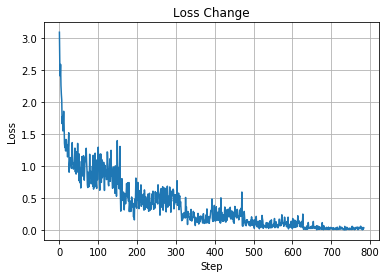

global_step = %s, average loss = %s 785 0.38100796780329504


In [68]:
main()